# Neural Network - MLP

In [ ]:
# !pip install tensorflow

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

: 

: 

In [1]:
# Helper function to plot training mae and mse across epochs later
def plot_error_epochs(history_results, metrics='mae'):

  plt.plot(history_results.history[metrics])
  plt.plot(history_results.history['val_'+metrics])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Load HDB Dataset

In [ ]:
dataset = pd.read_csv("../data/backup/merge_data.csv")
important_cols = ['flat_type',
 'floor_area_sqm',
 'lease_commence_date',
 'resale_price',
 'rebased_month',
 '3-room',
 '5-room',
 'executive',
 'flat_type_price',
 'flat_type_number',
 'storey_range_price',
 'storey_range_price_psm',
 'flat_model_price',
 'flat_model_psm',
 'grid_price',
 'subzone_price',
 'subzone_price_psm',
 'street_name_price',
 'street_name_price_psm']

# Build fully connected MLP with 2 hidden layers

- The structure is 5x4x10x1
- Use Relu as Activation Function
- Go for Adam for Optimizer

Tutorial suggest to use batch size of 15. 

# Bonus
- Try to visualize training error vs. epoch curve

In [457]:
# Perform a 90-10 train test split
X_train, X_test, y_train, y_test = train_test_split(dataset[["town", "flat_type", "floor_area_sqm", "flat_model", "lease_commence_date"]], \
                 dataset["resale_price"], test_size=0.1, random_state=42)

In [458]:
# Perform shuffling of training data, so that batches can be more representative
training_df = pd.concat([X_train, y_train], axis=1)
random.seed(42)
shuffled_training_df = training_df.sample(frac=1)

X_train = shuffled_training_df[X_train.columns]
y_train = shuffled_training_df.iloc[:, -1]

In [585]:
# Save shuffled data
# X_train.to_csv("/content/drive/MyDrive/Masters - Neural Nets/X_train_after_shuffle_v2.csv")
# X_test.to_csv("/content/drive/MyDrive/Masters - Neural Nets/X_test_after_shuffle_v2.csv")

In [596]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1800, 5)
X_test shape:  (200, 5)
y_train shape:  (1800,)
y_test shape:  (200,)


In [565]:
# Train a min-max scaler on the train dataset, and transform on both train and test
sc = MinMaxScaler()
sc_train = sc.fit(X_train)
X_train_scaled = sc_train.transform(X_train)
X_test_scaled = sc_train.transform(X_test)

# Scale data down by 100,000 
y_train_scaled = y_train/100000
y_test_scaled = y_test/100000

# Save scaler using pickle
# pickle.dump(sc_train, open('/content/drive/MyDrive/Masters - Neural Nets/sc_mlp.pkl','wb'))
# pickle.dump(sc_train, open('/content/drive/MyDrive/Masters - Neural Nets/sc_mlp_v2.pkl','wb'))

In [800]:
# Building the architecture: Fully connected MLP with 2 hidden layers
tf.keras.backend.clear_session() 
initializer = tf.keras.initializers.RandomUniform(minval=0.,maxval=1.) # Random initializer to prevent local optima
mlp_model = Sequential()
mlp_model.add(Dense(4, input_dim=5, activation='relu', kernel_initializer=initializer)) # Hidden layer 1
mlp_model.add(Dense(10, activation='relu')) # Hidden layer 2
mlp_model.add(Dense(1, activation='linear')) 

In [801]:
mlp_model.summary()
# Number of parameters = (5*4) + (4*10) + (10*1) + (5+4+10+1) = 85.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 24        
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


In [802]:
# Use a Adam Optimizer - include learning rate to control the step size, the learning has optimized between 0.01 to 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=0.08)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# Compile the model with specified optimizer, loss function and metrics
mlp_model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])

In [579]:
# Saved best model that generate lowest MAE and MSE score for both training and test
# pickle.dump(mlp_model, open('/content/drive/MyDrive/Masters - Neural Nets/mlp_model.pkl', 'wb'))
# pickle.dump(mlp_model, open('/content/drive/MyDrive/Masters - Neural Nets/mlp_model_v2.pkl', 'wb'))

In [572]:
# Fit the model and store history of metrics for each epoch
history = mlp_model.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=72, validation_data=[X_test_scaled, y_test_scaled], callbacks=[es])

# Exp 1: StandardScaler, LR: 0.01, Epoch: 600, Batch Size = 72, Testing MAE::: 66517.593
# Exp 2: StandardScaler, LR: 0.01, Epoch: 600, Batch Size = 20, Testing MAE::: 68145.209
# Exp 3: StandardScaler, LR: 0.01, Epoch: 600, Batch Size = 30, Testing MAE::: 68033.108
# Exp 4: StandardScaler, LR: 0.01, Epoch: 600, Batch Size = 72, Testing MAE::: 68085.023
# Exp 5: StandardScaler, LR: 0.01, Epoch: 600, Batch Size = 120, Testing MAE::: 67390.194
# Exp 6: StandardScaler, LR: 0.01, Epoch: 600, Batch Size = 150, Testing MAE::: 68092.642
# Exp 7: Min Max Scaler, LR: 0.01, Epoch: 600, Batch Size = 72, Testing MAE::: 67977.363, 
# Exp 8: Min Max Scaler, LR: 0.01, Epoch: 600, Batch Size = 72, Testing MAE::: 65158.743
# Exp 9: Min Max Scaler, LR: 0.05, Epoch: 600, Batch Size = 72, Testing MAE::: 64175.845
# Exp 10: Min Max Scaler, LR: 0.1, Epoch: 600, Batch Size = 72, Testing MAE::: 63537.897
# Exp 11: Min Max Scaler, LR: 0.08, Epoch: 400, Batch Size = 72, Testing MAE::: 63272.255

Epoch 1/400
25/25 [==============================] - 1s 11ms/step - loss: 1.1831 - mae: 1.1831 - mse: 2.5342 - val_loss: 0.9064 - val_mae: 0.9064 - val_mse: 1.2535
Epoch 2/400
25/25 [==============================] - 0s 4ms/step - loss: 0.7101 - mae: 0.7101 - mse: 1.0180 - val_loss: 0.7113 - val_mae: 0.7113 - val_mse: 0.9223
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 0.6355 - mae: 0.6355 - mse: 0.8639 - val_loss: 0.6825 - val_mae: 0.6825 - val_mse: 0.8752
Epoch 4/400
25/25 [==============================] - 0s 5ms/step - loss: 0.6394 - mae: 0.6394 - mse: 0.8882 - val_loss: 0.6812 - val_mae: 0.6812 - val_mse: 0.8667
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 0.6358 - mae: 0.6358 - mse: 0.8778 - val_loss: 0.6776 - val_mae: 0.6776 - val_mse: 0.8603
Epoch 6/400
25/25 [==============================] - 0s 4ms/step - loss: 0.6568 - mae: 0.6568 - mse: 0.9313 - val_loss: 0.7261 - val_mae: 0.7261 - val_mse: 1.0667
Epoch 7/400
25/25 [==

## Visualize training and testing error vs. epochs curve

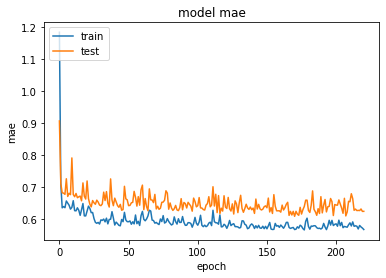

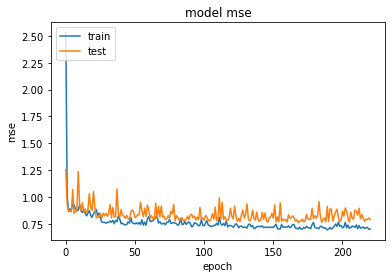

In [573]:
# Plot training and testing error vs. epochs curve
plot_error_epochs(history, metrics='mae')
plot_error_epochs(history, metrics='mse')

In [ ]:
# Reopen mlp model that gives best results
# loaded_model = pickle.load(open('/content/drive/MyDrive/Masters - Neural Nets/mlp_model.pkl', 'rb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Masters - Neural Nets/mlp_model_v2.pkl', 'rb'))

In [590]:
# Get predicted house price on training data
yhat_train = 100000*loaded_model.predict(X_train_scaled)

# MLP: Training MSE and MAE
print('Training MSE::: %.3f' % mean_squared_error(y_train, yhat_train))
print('Training MAE::: %.3f' % mean_absolute_error(y_train, yhat_train))

57/57 [==============================] - 0s 1ms/step
Training MSE::: 6819496061.767
Training MAE::: 56109.695


In [591]:
# Get predicted house price on testing data
yhat_test = 100000*loaded_model.predict(X_test_scaled)

# MLP: Testing MSE MAE
print('Testing MSE::: %.3f' % mean_squared_error(y_test, yhat_test))
print('Testing MAE::: %.3f' % mean_absolute_error(y_test, yhat_test))

7/7 [==============================] - 0s 2ms/step
Testing MSE::: 7884352648.042
Testing MAE::: 62452.905


## Try different normalization approach 

In [790]:
# Train a standard scaler on the train dataset, and transform on both train and test
sc_standard = StandardScaler()
sc_train_standard = sc_standard.fit(X_train)
X_train_scaled_standard = sc_train_standard.transform(X_train)
X_test_scaled_standard = sc_train_standard.transform(X_test)

In [798]:
# pickle.dump(sc_train_standard, open('/content/drive/MyDrive/Masters - Neural Nets/sc_mlp_standard.pkl','wb'))
# sc_train_standard = pickle.load(open('/content/drive/MyDrive/Masters - Neural Nets/sc_mlp_standard.pkl', 'rb'))

In [803]:
# Fit model using standard scaled input features
history_standard = mlp_model.fit(X_train_scaled_standard, y_train_scaled, epochs=400, batch_size=72, validation_data=[X_test_scaled_standard, y_test_scaled], callbacks=[es])

25/25 [==============================] - 0s 6ms/step - loss: 0.5825 - mae: 0.5825 - mse: 0.7212 - val_loss: 0.6387 - val_mae: 0.6387 - val_mse: 0.8866
Epoch 25/400
25/25 [==============================] - 0s 7ms/step - loss: 0.6080 - mae: 0.6080 - mse: 0.7518 - val_loss: 0.6165 - val_mae: 0.6165 - val_mse: 0.8736
Epoch 26/400
25/25 [==============================] - 0s 6ms/step - loss: 0.5952 - mae: 0.5952 - mse: 0.7380 - val_loss: 0.6180 - val_mae: 0.6180 - val_mse: 0.8355
Epoch 27/400
25/25 [==============================] - 0s 6ms/step - loss: 0.5923 - mae: 0.5923 - mse: 0.7427 - val_loss: 0.6691 - val_mae: 0.6691 - val_mse: 0.9367
Epoch 28/400
25/25 [==============================] - 0s 5ms/step - loss: 0.5885 - mae: 0.5885 - mse: 0.7168 - val_loss: 0.6525 - val_mae: 0.6525 - val_mse: 0.8943
Epoch 29/400
25/25 [==============================] - 0s 5ms/step - loss: 0.5974 - mae: 0.5974 - mse: 0.7420 - val_loss: 0.6965 - val_mae: 0.6965 - val_mse: 0.9885
Epoch 30/400
25/25 [=========

In [ ]:
# pickle.dump(mlp_model, open('/content/drive/MyDrive/Masters - Neural Nets/mlp_model_standard.pkl','wb'))
loaded_model_standard = pickle.load(open('/content/drive/MyDrive/Masters - Neural Nets/mlp_model_standard.pkl', 'rb'))

In [808]:
# Get predicted house price on training data
yhat_train_standard = 100000*loaded_model_standard.predict(X_train_scaled_standard)

# MLP: Training MSE and MAE
print('Training MSE::: %.3f' % mean_squared_error(y_train, yhat_train_standard))
print('Training MAE::: %.3f' % mean_absolute_error(y_train, yhat_train_standard))

57/57 [==============================] - 0s 3ms/step
Training MSE::: 6917749044.582
Training MAE::: 57124.618


In [809]:
# Get predicted house price on testing data
yhat_test_standard = 100000*loaded_model_standard.predict(X_test_scaled_standard)

# MLP: Testing MSE MAE
print('Testing MSE::: %.3f' % mean_squared_error(y_test, yhat_test_standard))
print('Testing MAE::: %.3f' % mean_absolute_error(y_test, yhat_test_standard))

7/7 [==============================] - 0s 3ms/step
Testing MSE::: 9073596929.711
Testing MAE::: 66526.929


# Build Deep Convolutional-NN

- 2 1-D CNN layer
- Having pooling and batch normalization layer is optional
- Include dropout
- Other hyperparameters are optional and setting is up to me
- Should print training and testing MAE and MSE

# Bonus
- Try to visualize training error vs. epoch curve
- Try different dropout rates and see the differences

In [682]:
# Reshape X_train
sample_size = X_train_scaled.shape[0] # number of samples in train set
time_steps  = X_train_scaled.shape[1] # number of features in train set
input_dimension = 1                   # each feature is represented by 1 number

X_train_reshaped = X_train_scaled.reshape(sample_size, time_steps, input_dimension)
train_timesteps = X_train_reshaped.shape[1] 
train_features  = X_train_reshaped.shape[2] 
print("After reshape train data set shape:\n", X_train_reshaped.shape)
print("1 Sample shape:\n",X_train_reshaped[0].shape)
print("An example sample:\n", X_train_reshaped[0])

X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1],1)
print("After reshape test data set shape:\n", X_test_reshaped.shape)
print("1 Sample shape:\n",X_test_reshaped[0].shape)
print("An example sample:\n", X_test_reshaped[0])

After reshape train data set shape:
 (1800, 5, 1)
1 Sample shape:
 (5, 1)
An example sample:
 [[0.04      ]
 [0.2       ]
 [0.22758621]
 [0.6       ]
 [0.39130435]]
After reshape test data set shape:
 (200, 5, 1)
1 Sample shape:
 (5, 1)
An example sample:
 [[0.92      ]
 [0.4       ]
 [0.46206897]
 [0.33333333]
 [0.69565217]]


In [786]:
print("No. of timesteps:", train_timesteps)
print("No. of features:", train_features)

No. of timesteps: 5
No. of features: 1


In [769]:
def build_conv1D_model(n_timesteps, n_features, dropout_rates=0.5):
  
  tf.keras.backend.clear_session() 
  model = tf.keras.Sequential(name="model_conv1D")
  model.add(tf.keras.layers.Input(shape=(n_timesteps,n_features)))

  model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name="Conv1D_1")) # padding is default, 'valid'
  model.add(tf.keras.layers.BatchNormalization()) # Handles internal covariate shift, provides some form of regularization and overfitting

  model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2")) # padding is default, 'valid'
  model.add(tf.keras.layers.BatchNormalization()) 
  model.add(tf.keras.layers.MaxPooling1D(pool_size=1, name="MaxPooling1D"))
  model.add(tf.keras.layers.Dropout(dropout_rates))
  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(n_features, name="Dense", kernel_initializer="normal"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) 
  model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

In [770]:
model_conv1D = build_conv1D_model(n_timesteps=train_timesteps, n_features=train_features, dropout_rates=0.25)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 3, 64)             256       
                                                                 
 batch_normalization (BatchN  (None, 3, 64)            256       
 ormalization)                                                   
                                                                 
 Conv1D_2 (Conv1D)           (None, 1, 32)             6176      
                                                                 
 batch_normalization_1 (Batc  (None, 1, 32)            128       
 hNormalization)                                                 
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 1, 32)            0         
                                                                 
 dropout (Dropout)           (None, 1, 32)            

In [771]:
# Fit the model and store history of metrics for each epoch
history = model_conv1D.fit(X_train_reshaped, y_train_scaled, epochs=800, batch_size=240, validation_data=[X_test_reshaped, y_test_scaled])

# Exp 1: Min Max Scaler, padding='same', LR: 0.08, Epoch: 600, Batch Size: 240, Dropout=0.5, Maxpooling=1, Testing MAE::: 67304.044
# Exp 2: Min Max Scaler, padding='valid', LR: 0.08, Epoch: 600, Batch Size: 240, Dropout=0.5, Maxpooling=1, Testing MAE::: 65930.067
# Exp 3: Min Max Scaler, padding='valid', LR: 0.08, Epoch: 600, Batch Size: 240, Dropout=0.5, Maxpooling=1, Batch Normalization, Testing MAE::: 62693.567
# Exp 4: Min Max Scaler, padding='valid', LR: 0.01, Epoch: 1000, Batch Size: 240, Dropout=0.5, Maxpooling=1, Batch Normalization, Testing MAE::: 60688.319
# Exp 5 (Model v1): Min Max Scaler, padding='valid', LR: 0.01, Epoch: 800, Batch Size: 240, Dropout=0.25, Maxpooling=1, Batch Normalization, mse, Testing MAE::: 62241.727
# Exp 6 (Model v2): Min Max Scaler, padding='valid', LR: 0.01, Epoch: 800, Batch Size: 240, Dropout=0.25, Maxpooling=1, Batch Normalization, mae, 


Epoch 1/800
8/8 [==============================] - 3s 59ms/step - loss: 4.4379 - mae: 4.4379 - mse: 21.6040 - val_loss: 4.4764 - val_mae: 4.4764 - val_mse: 21.9159
Epoch 2/800
8/8 [==============================] - 0s 13ms/step - loss: 4.0424 - mae: 4.0424 - mse: 18.4999 - val_loss: 3.9490 - val_mae: 3.9490 - val_mse: 17.5517
Epoch 3/800
8/8 [==============================] - 0s 14ms/step - loss: 3.1837 - mae: 3.1837 - mse: 12.8495 - val_loss: 2.6103 - val_mae: 2.6103 - val_mse: 8.8568
Epoch 4/800
8/8 [==============================] - 0s 13ms/step - loss: 1.8411 - mae: 1.8411 - mse: 5.6043 - val_loss: 1.1675 - val_mae: 1.1675 - val_mse: 2.6843
Epoch 5/800
8/8 [==============================] - 0s 17ms/step - loss: 1.2278 - mae: 1.2278 - mse: 2.6312 - val_loss: 1.4478 - val_mae: 1.4478 - val_mse: 3.5107
Epoch 6/800
8/8 [==============================] - 0s 10ms/step - loss: 1.1928 - mae: 1.1928 - mse: 2.3669 - val_loss: 2.1246 - val_mae: 2.1246 - val_mse: 6.0862
Epoch 7/800
8/8 [======

## Visualize training and testing error vs. epochs curve

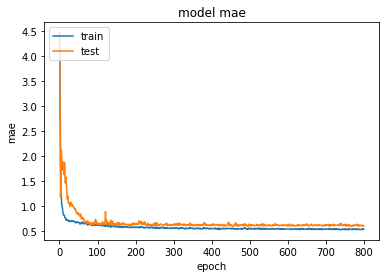

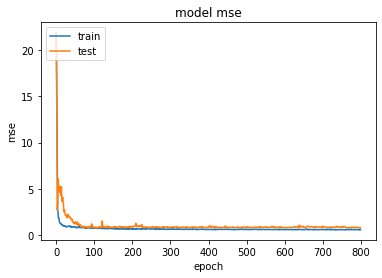

In [772]:
# Plot training and testing error vs. epochs curve
plot_error_epochs(history, metrics='mae')
plot_error_epochs(history, metrics='mse')

In [ ]:
# pickle.dump(model_conv1D, open('/content/drive/MyDrive/Masters - Neural Nets/conv1D_model_v1.pkl', 'wb'))
# loaded_model = pickle.load(open('/content/drive/MyDrive/Masters - Neural Nets/conv1D_model_v1.pkl', 'rb'))

# Save model
# pickle.dump(model_conv1D, open('/content/drive/MyDrive/Masters - Neural Nets/conv1D_model_v2.pkl', 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Masters - Neural Nets/conv1D_model_v2.pkl', 'rb'))

In [787]:
# Get predicted house price on training data
yhat_train = 100000*loaded_model.predict(X_train_scaled)

# MLP: Training MSE and MAE
print('Training MSE::: %.3f' % mean_squared_error(y_train, yhat_train))
print('Training MAE::: %.3f' % mean_absolute_error(y_train, yhat_train))

57/57 [==============================] - 0s 4ms/step
Training MSE::: 5237596634.121
Training MAE::: 49193.366


In [789]:
# Get predicted house price on testing data
yhat_test = 100000*loaded_model.predict(X_test_scaled)

# MLP: Testing MSE MAE
print('Testing MSE::: %.3f' % mean_squared_error(y_test, yhat_test))
print('Testing MAE::: %.3f' % mean_absolute_error(y_test, yhat_test))

7/7 [==============================] - 0s 2ms/step
Testing MSE::: 7932470357.872
Testing MAE::: 59405.633


## Different dropout rates and see difference

Constructing model for dropout: 0.1
Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 3, 64)             256       
                                                                 
 batch_normalization (BatchN  (None, 3, 64)            256       
 ormalization)                                                   
                                                                 
 Conv1D_2 (Conv1D)           (None, 1, 32)             6176      
                                                                 
 batch_normalization_1 (Batc  (None, 1, 32)            128       
 hNormalization)                                                 
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 1, 32)            0         
                                                                 
 dropout (Dropout)

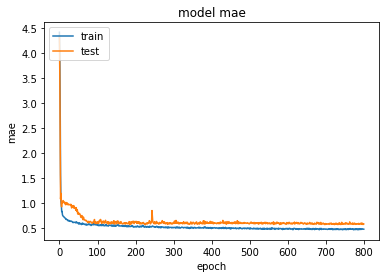

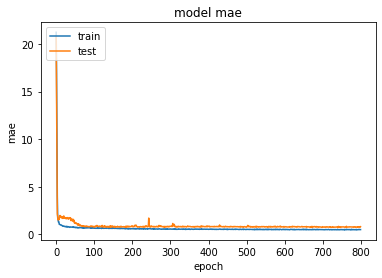

Generate Training MAE and MSE for dropout: 0.1
57/57 [==============================] - 0s 2ms/step
Training MSE::: 5026317625.551
Training MAE::: 47060.499
7/7 [==============================] - 0s 4ms/step
Testing MSE::: 8032678502.182
Testing MAE::: 58848.765
Constructing model for dropout: 0.5
Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 3, 64)             256       
                                                                 
 batch_normalization (BatchN  (None, 3, 64)            256       
 ormalization)                                                   
                                                                 
 Conv1D_2 (Conv1D)           (None, 1, 32)             6176      
                                                                 
 batch_normalization_1 (Batc  (None, 1, 32)            128       
 hNormalization)   

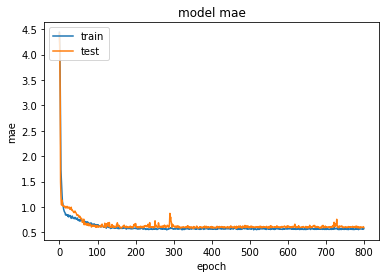

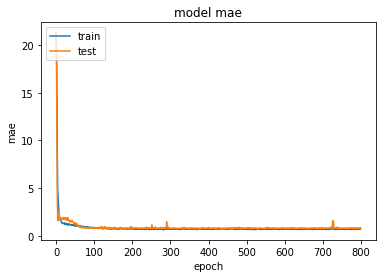

Generate Training MAE and MSE for dropout: 0.5
57/57 [==============================] - 0s 2ms/step
Training MSE::: 5738679706.375
Training MAE::: 50760.557
7/7 [==============================] - 0s 3ms/step
Testing MSE::: 7873380038.314
Testing MAE::: 59452.140


In [785]:
# Drop out of 0.25 has been used, trying out smaller (0.1) and larger (0.5) drop out rates
for dropout in [0.1, 0.5]:

  print("Constructing model for dropout:", dropout)
  model_dropout = build_conv1D_model(n_timesteps=train_timesteps, n_features=train_features, dropout_rates=dropout)
  model_dropout.summary()
  history_testing = model_dropout.fit(X_train_reshaped, y_train_scaled, epochs=800, batch_size=240, validation_data=[X_test_reshaped, y_test_scaled], verbose=0)
  
  print("Error vs. Epoch curve for dropout rate:", dropout)
  plot_error_epochs(history_testing, metrics='mae')
  plot_error_epochs(history_testing, metrics='mse')

  print("Generate Training MAE and MSE for dropout:", dropout)
  yhat_train = 100000*model_dropout.predict(X_train_scaled)
  print('Training MSE::: %.3f' % mean_squared_error(y_train, yhat_train))
  print('Training MAE::: %.3f' % mean_absolute_error(y_train, yhat_train))

  yhat_test = 100000*model_dropout.predict(X_test_scaled)
  print('Testing MSE::: %.3f' % mean_squared_error(y_test, yhat_test))
  print('Testing MAE::: %.3f' % mean_absolute_error(y_test, yhat_test))



Comment on drop out: 0.1, 0.25, and 0.5. 
The difference in testing mae vs. training mae are: 11788, 10212 and 8692. As the dropout rate increases (with all other hyperparameters), the training error and testing error comes closer together i.e. less overfitting. However it is worth noting that although overfitting is gradually reduced, the training and testing mae scores increases as well. Training mae scores were 47060, 49193, 50760; while testing mae scores were 58848, 59405, and 59452. This can be solved by adjusting other parameters such as filter size and kernel size. 

